In [1]:
print ("Importing all packages and Google BQ credentials files")
import warnings
warnings.filterwarnings("ignore")
import pandas as pd,os
from oauth2client.service_account import ServiceAccountCredentials
import gspread
import gspread_dataframe as gd
import psycopg2
import df2gspread as d2g
import numpy as np
import re
import calendar
import time,datetime
import json
import pytz
my_timezone = pytz.timezone('Asia/Calcutta')
import ast
import gzip
from datetime import timedelta
from google.oauth2 import service_account
from google.cloud import bigquery
import pandas_gbq
from IPython.display import display
import datetime
from dateutil import relativedelta

KEY_PATH = "data-warehouse-india-copy-5949defd88ea.json"
CREDS = service_account.Credentials.from_service_account_file(KEY_PATH)
bq_client = bigquery.Client(credentials=CREDS, project="data-warehouse-india-copy")


pd.set_option('display.max_columns',100)



print ("Connecting to Postgres using psycopg2")
connection = psycopg2.connect(user="keshavkumar",
                                      password="J3@!@@s..o90&2U$32-",
                                      host="localhost",
                                      port=55432,
                                      database="rain")
cursor = connection.cursor()
# Print PostgreSQL details
print("PostgreSQL server information")
print(connection.get_dsn_parameters(), "\n")
# cursor.itersize = 10000
cursor.execute("SELECT version();")
    # Fetch result
record = cursor.fetchone()
print("You are connected to - ", record, "\n")

print ("Function to download Postgres data and concert that to dataframe")
def dataframe_generator(query):
    cursor.execute(query)
    print('Read table in PostgreSQL')
    data = cursor.fetchall()
    cols = []
    for elt in cursor.description:
        cols.append(elt[0])
    df= pd.DataFrame(data = data, columns=cols)
    return df

print ("Function to clean dataframe to include only data post Sept 1, 2021")
def clean(df):
    df["created_at"] = df["created_at"].dt.date.astype(str)
    df = df[df["created_at"]>"2021-08-31"]
    return df



Importing all packages and Google BQ credentials files
Connecting to Postgres using psycopg2
PostgreSQL server information
{'user': 'keshavkumar', 'dbname': 'rain', 'host': 'localhost', 'port': '55432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 12.8 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',) 

Function to download Postgres data and concert that to dataframe
Function to clean dataframe to include only data post Sept 1, 2021


In [9]:
print ("Connecting to Big Query Table")
query_string = "select * FROM `data-warehouse-india.Processed_data.withdrawals-txns_without_bank`"
all_trxn = pd.read_gbq(query_string, project_id="data-warehouse-india")

Connecting to Big Query Table


In [11]:
data = all_trxn[['disbursal_txn__date','user_id','Total_Amount']]

In [12]:
data.disbursal_txn__date=pd.to_datetime(data.disbursal_txn__date).dt.date

In [13]:
data.Total_Amount=data.Total_Amount.astype('float')

In [17]:
pre_au4 = data.groupby('disbursal_txn__date').apply(lambda x: x['user_id'].tolist()).reset_index()
pre_au4.columns=['disbursal_txn__date','user_list']

In [39]:
def au4_new_user_finder(date):
    min_date = pre_au4.disbursal_txn__date.min()
    current_date = pd.to_datetime(date,format='%Y-%m-%d')
    if current_date==min_date:
        new_user=set(pre_au4.loc[pre_au4.disbursal_txn__date==current_date,'user_list'].values[0])
    else:
        last_date = current_date-relativedelta.relativedelta(day=1)
        back_dated_df = pre_au4[(pre_au4.disbursal_txn__date<=last_date)&(pre_au4.disbursal_txn__date>=min_date)]
        existing_user=[]
        for userlst in back_dated_df.user_list:
            for user in userlst:
                existing_user.append(user)
        existing_users = set(existing_user)
        current_date_userlst = set(pre_au4.loc[pre_au4.disbursal_txn__date==current_date,'user_list'].values[0])
        new_user=current_date_userlst-existing_users
    return new_user

In [40]:
len(au4_new_user_finder('2022-06-10'))

50

In [41]:
au4_df=[]
for date in pre_au4.disbursal_txn__date:
    au4_df.append((date,len(au4_new_user_finder(date))))
    

In [50]:
final_df = pd.DataFrame(au4_df)
final_df.columns=['date','Au4_Count']
final_df.to_excel('Daily_Au4_Count.xlsx',index=False)

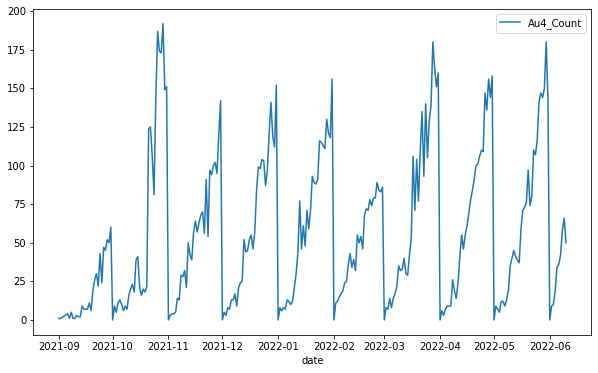

In [49]:
final_df.plot(x='date',y='Au4_Count',figsize=(10,6));
